# Negation scope - with bag of words
## Loading dataset

In [1]:
from datetime import datetime
from negation_scope_common import create_semi_dataset, create_vectorizer, create_columns_names
from negation_scope_common import create_features_list, save_to_csv
from utils import get_datasets


def create_dataset(dataset, sufix):
    ouput_name = '{}.csv'.format(dataset[:-4])
    print('{} START Creating semi dataset {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train, X_test = create_semi_dataset(dataset)
    vect_lemma = create_vectorizer(X_train)
    column_names = create_columns_names(X_train, vect_lemma, add_bow=True)
    print('{} START Creating features list {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train_features_list = create_features_list(X_train, vect_lemma, add_bow=True)
    X_test_features_list = create_features_list(X_test, vect_lemma, add_bow=True)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    save_to_csv(ouput_name + sufix + '-train', column_names, X_train_features_list)
    save_to_csv(ouput_name + sufix + '-test', column_names, X_test_features_list)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))


for dataset in get_datasets():
    create_dataset(dataset, '-sco-bow')

2017-05-02 17:12:46 START Creating semi dataset dataset/beletria/merged.xml


2017-05-02 17:12:46 START Creating features list dataset/beletria/merged.xml


2017-05-02 17:13:35 START Save csv dataset/beletria/merged.xml


2017-05-02 17:13:56 START Save csv dataset/beletria/merged.xml


2017-05-02 17:13:57 START Creating semi dataset dataset/recenzie/merged.xml


2017-05-02 17:13:57 START Creating features list dataset/recenzie/merged.xml


2017-05-02 17:14:32 START Save csv dataset/recenzie/merged.xml


2017-05-02 17:14:40 START Save csv dataset/recenzie/merged.xml
2017-05-02 17:14:41 START Creating semi dataset dataset/snk/merged.xml
2017-05-02 17:14:41 START Creating features list dataset/snk/merged.xml


2017-05-02 17:15:56 START Save csv dataset/snk/merged.xml


2017-05-02 17:16:47 START Save csv dataset/snk/merged.xml
2017-05-02 17:16:48 START Creating semi dataset dataset/sport/merged.xml


2017-05-02 17:16:49 START Creating features list dataset/sport/merged.xml


2017-05-02 17:17:44 START Save csv dataset/sport/merged.xml


2017-05-02 17:18:13 START Save csv dataset/sport/merged.xml
2017-05-02 17:18:14 START Creating semi dataset dataset/vlastne_mario/merged.xml
2017-05-02 17:18:14 START Creating features list dataset/vlastne_mario/merged.xml


2017-05-02 17:18:18 START Save csv dataset/vlastne_mario/merged.xml


2017-05-02 17:18:19 START Save csv dataset/vlastne_mario/merged.xml


In [2]:
create_dataset('dataset/snk/merged.xml', '-sco-bow')

2017-05-02 15:55:05 START Creating semi dataset dataset/snk/merged.xml


2017-05-02 15:55:05 START Creating features list dataset/snk/merged.xml


2017-05-02 15:57:10 START Save csv dataset/snk/merged.xml


2017-05-02 15:58:27 START Save csv dataset/snk/merged.xml


## Training

In [10]:
%%time
import pandas as pd

# Load dataset
df_train = pd.read_csv('dataset/snk/merged.csv-sco-bow-train')
df_test = pd.read_csv('dataset/snk/merged.csv-sco-bow-test')

df2_train = df_train[df_train.columns.difference(['token', 'lemma', 'POS', 'is_in_scope', 'negator_pos', 'word5_žiť'])]
df2_test = df_test[df_test.columns.difference(['token', 'lemma', 'POS', 'is_in_scope', 'negator_pos', 'word5_žiť'])]

CPU times: user 30.6 s, sys: 3.02 s, total: 33.6 s
Wall time: 37.1 s


In [11]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC

# model = MultinomialNB()
model = GaussianNB()
# model = BernoulliNB()
# model = SVC()

# Train the model using the training sets 
model.fit(df2_train, df_train.is_in_scope)

CPU times: user 7.57 s, sys: 2.66 s, total: 10.2 s
Wall time: 12.1 s


## Metrics

In [12]:
from sklearn import metrics

y_pred = model.predict(df2_test)
y_true = df_test.is_in_scope

print('Accuracy: {}'.format(metrics.accuracy_score(y_true, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_true, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_true, y_pred)))
print('F1 score: {}'.format(metrics.f1_score(y_true, y_pred)))

print(metrics.classification_report(y_true, y_pred))

Accuracy: 0.9814671814671815
Precision: 1.0
Recall: 0.35135135135135137
F1 score: 0.52
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2516
          1       1.00      0.35      0.52        74

avg / total       0.98      0.98      0.98      2590



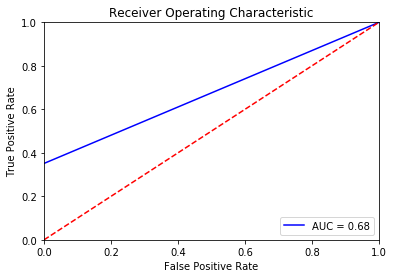

In [13]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# Grid Search for Algorithm Tuning
from sklearn.model_selection import GridSearchCV
# prepare a range of alpha values to test
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
# create and fit a ridge regression model, testing each alpha
model = MultinomialNB()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(df2_train, df_train.is_negation)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
0.957593123209
1.0


In [ ]:
import pickle
with open('model-gaussian-sco.pkl', 'wb') as fout:
    pickle.dump(model, fout)

## Playground

In [8]:
df2_train
df2_train.columns[df2_train.isnull().any()].tolist()

['word5_žiť']

In [ ]:
df2_train.loc[:, df2_train.isnull().any()]

In [9]:
df_train

,token,lemma,POS,has_sk_prefix,has_int_prefix,is_particle,word_without_prefix_exist,start_with_ne,is_in_scope,is_negator,...,word5_žabka,word5_že,word5_žena,word5_ženský,word5_žiaden,word5_žiadosť,word5_živkoviča,word5_život,word5_životný,word5_žiť
0,Na,na,Eu4,False,False,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,rozdiel,rozdiel,SSis4,True,False,False,True,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
2,od,od,Eu2,False,False,False,False,0,0,2,...,0,0,0,0,0,0,0,0,0,NaN
3,Descartesa,Descartesa,NUnp2,False,False,False,False,0,0,3,...,0,0,0,0,0,0,0,0,0,NaN
4,ďalší,ďalší,AAms1x,False,False,False,False,0,0,4,...,0,0,0,0,0,0,0,0,0,NaN
5,významný,významný,AAms1x,False,False,False,False,0,0,5,...,0,0,0,0,0,0,0,0,0,NaN
6,racionalista,racionalista,SSms1,False,False,False,False,0,0,6,...,0,0,0,0,0,0,0,0,0,NaN
7,novoveku,novovek,SSis2,False,False,False,False,0,0,7,...,0,0,0,0,0,0,0,0,0,NaN
8,",",",",Z,False,False,False,False,0,0,8,...,0,0,0,0,0,0,0,0,0,NaN
9,holandský,holandský,AAms1x,False,False,False,False,1,0,9,...,0,0,0,0,0,0,0,0,0,NaN
